# Black-Scholes-Merton option modeling

This notebook showcases the expressive power of vectorized code, plotting, and interactivity via widgets. We apply these techniques to Monte Carlo-based and closed form European call option pricing. 

##  market model

We assume that the price of a stock follows the geometric Brownian motion process described by Black-Scholes-Merton. The stock has a starting price $S_0$. The risk-free interest rate $r$ represent the time value of money. Stock volatility $\sigma$ describes how quickly the stock price moves. The call option is an option to buy at a strike price $K$ expiring at time $T$. The price at time $T$ is given by $S=S_0 e^{(r-\frac{1}{2}\sigma^2)T + \sigma \sqrt{T} Z}$, where $Z$ is a random variable that has a standard normal distribution (mean zero, variance one).

For our example, let's assume the stock price is currently 100 USD, and we have the option to buy the stock at 105 USD in 3 months. The annual volatility of the stock is 40%, and the risk-free rate is 3%.

Note the use of NumPy's [random.normal](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.random.normal.html) function. Also, note that we alias <code>numpy</code> to <code>np</code>. You can choose your own aliases, but there are [Python library alias conventions](https://www.quantifiedcode.com/knowledge-base/readability/Use%20common%20abbreviations%20for%20libraries/7jRPIvMK) that you can follow to make your code more readable for others. 

In [59]:
import math
import numpy as np

def bsm(s_0, r, sigma, t, z):
    return s_0*np.exp((r-1.0/2*sigma**2)*t+sigma*z*t**(1.0/2))

print bsm(100, 0.03, 0.4, 3.0/12, np.random.standard_normal())

87.3143887045


## vector-based market model

The <code>bsm</code> function above can generate a single observation from the distribution of prices at time $T$. Since we are using a Monte Carlo appproach, however, we will want $n$ simulations. In a language like Java or C++, a typical approach might be to call <code>bsm</code> $N$ times. But NumPy provides support for vectorizing calculations, making code faster and more concise. We can make a small modification to vectorize our <code>bsm</code> function, by replacing <code>math.exp</code> with <code>numpy.exp</code>.

In [60]:
def bsm(s_0, r, sigma, t, z):
    return s_0*np.exp((r-1.0/2*sigma**2)*t+sigma*z*t**(1.0/2))

n = 10
print bsm(100, 0.03, 0.4, 3.0/12, np.random.standard_normal(n))

[  88.54434749   99.9990661   110.27416979   87.5383004   106.07002783
  107.39148637  103.70546595   85.83864791   92.49986786   99.02630091]


## histogram of price distribution

We have a collection of random prices. It would be helpful to see what the distribution looks like. For that, we use [matplotlib](http://matplotlib.org).

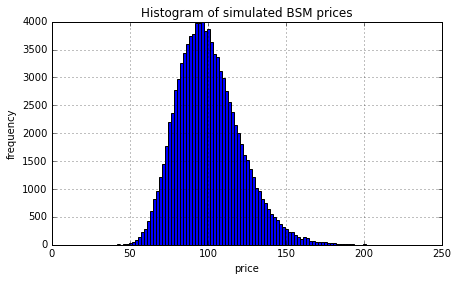

In [61]:
 #needed for plot to appear in Jupyter
%matplotlib inline 
import matplotlib.pyplot as plt

n = 100000
prices = bsm(100,0.03,0.4,3.0/12,np.random.standard_normal(n))
plt.figure(figsize=(7,4))
plt.hist(prices,label=['prices'],bins = 100, color = 'blue')
plt.grid(True)
plt.xlabel('price')
plt.ylabel('frequency')
plt.title('Histogram of simulated BSM prices')

## making your plot more interactive

You can interact with Jupyter by entering values, and rerunning a cell. In the case of the histogram above, I might be interested in seeing the effect of changing the interest rate, volatility, or the time to expiry. Sliders are preferable for quickly exploring the effect of changing values over a range. For that, you can use [ipywidgets](https://github.com/ipython/ipywidgets). The README includes a tutorial that is also hosted [here](http://nbviewer.jupyter.org/github/quantopian/ipython/blob/master/examples/Interactive%20Widgets/Index.ipynb).

GitHub has done us the favor of rendering our notebooks. However, you cannot interact with the rendered notebook. There are some paid services that will host your notebook if you want others to explore it interactively. 

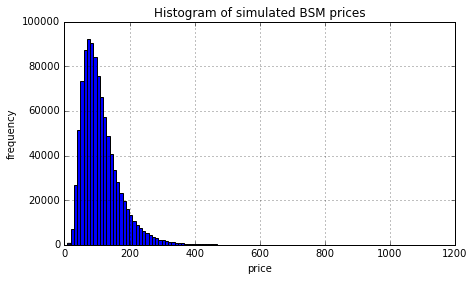

In [62]:
from ipywidgets import interact
def plot_histogram(r, sigma, t):
    n = 1000000
    prices = bsm(100,r,sigma,t,np.random.standard_normal(n))
    plt.figure(figsize=(7,4))
    plt.hist(prices,label=['prices'],bins = 100, color = 'blue')
    plt.grid(True)
    plt.xlabel('price')
    plt.ylabel('frequency')
    plt.title('Histogram of simulated BSM prices')

interact(plot_histogram,  r=(0.0, 0.2, 0.01), sigma=(0.01, 1.0, 0.01), t=(0.01, 2, 0.01));

## estimating expected stock price at expiry
I want to estimate the expected stock price at expiry, so I will compute the average of the sampled prices.

In [63]:
n = 1000000
print sum(bsm(100, 0.03, 0.4, 3.0/12, np.random.standard_normal(n)))/n


100.769722064


## estimating option price

The point of generating a distribution of stocks prices was to generate a distribution of the option value at maturity. The present value of the average option value at maturity is an estimate of what the option is worth today. 

In [64]:
n = 100000
r = 0.03
t = 3.0/12
stockPriceAtExpiry = bsm(100, r, 0.4, t, np.random.standard_normal(n))
strikePrice = 105
optionValuesAtExpiry = np.maximum(stockPriceAtExpiry - strikePrice,0)
averageForwardOptionValue = sum(optionValuesAtExpiry)/n
presentOptionValue = averageForwardOptionValue * math.exp(-r*t)
print presentOptionValue

6.18682935132


## closed-form BSM

How does this compare with the closed-form [Black-Scholes-Merton](https://en.wikipedia.org/wiki/Black–Scholes_model) model? 

$\begin{align}
  C(S, t) &= \Phi(d_1)S - \Phi(d_2) Ke^{-rt} \\
     d_1 &= \frac{1}{\sigma\sqrt{t}}\left[\ln\left(\frac{S}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)t\right] \\
     d_2 &= d_1 - \sigma\sqrt{t} \\
\end{align}$

where $\Phi$ is the standard normal cumulative distribution function. We use [norm](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) from scipy.stats.

In [65]:
from scipy.stats import norm
def call(s, r, sigma, t, k):
    d1 = 1/(sigma*t**(0.5))*(np.log(float(s)/k) + (r+sigma**2/2)*t)
    d2 = d1-sigma*t**(0.5)
    return norm.cdf(d1)*s-norm.cdf(d2)*k*np.exp(-r*t)
    

print call(100, 0.03, 0.4, 3.0/12, 105)

6.19785003662
